In [2]:
import numpy as np
import pandas as pd

from cde_diagnostics.local_test import local_test
from cde_diagnostics.global_test import global_test
from cde_diagnostics.local_pp_plot import local_pp_plot
from cde_diagnostics.local_plot import local_plot

import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.cde_loss import cde_loss
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1) Toy example data

## $Y \sim N(X_1+X_2,\ \ 1),\ \ \ X_1,X_2 \sim N(0,1),\ \ \rho(X_1,X_2) = 0.8$

In [3]:
def sample_X_Y_Z(rho=0.1, size=10000, var1=1, std2=1):
    joint_data = multivariate_normal.rvs(mean=[0,0], cov=var1*np.array([[1,rho],[rho,1]]), size=size)
    X_data = joint_data[:,0]
    Z_data = joint_data[:,1]
    Y_data = np.random.normal(loc=X_data+Z_data, scale=std2)
    return X_data, Y_data, Z_data

In [4]:
# sample points
rho = 0.8
size = 15500  # train 10000, val 5000, test 500
X_data, Y_data, Z_data = sample_X_Y_Z(rho=rho, size=size)

Text(0, 0.5, '$X_2$')

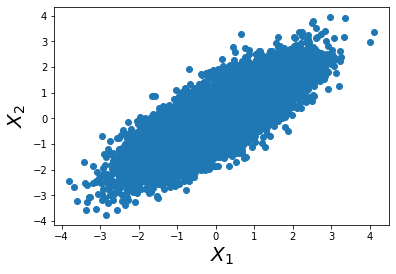

In [5]:
plt.scatter(X_data, Z_data)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)

# 2) Fit two CDE models

In [12]:
def fit_NNKCDE(k=50, x_train=XZ_train, z_train=Y_train):
    model = nnkcde.NNKCDE(k=k)
    model.fit(x_train=x_train, z_train=z_train)
    return model

In [13]:
def tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(20,110,10), x_train=XZ_train, z_train=Y_train,
              x_val=XZ_val, z_val=Y_val, n_grid=151, z_min=-15, z_max=15):
    z_grid = np.linspace(z_min, z_max, n_grid)
    CDE_losses = {}
    CDE_loss_SEs = {}
    for bw in bws:
        print(bw)
        CDE_losses[bw] = {}
        CDE_loss_SEs[bw] = {}
        for k in ks:
            print(k)
            model = fit_NNKCDE(k=k, x_train=x_train, z_train=z_train)
            cde_val = model.predict(x_val, z_grid, bandwidth=bw)
            loss, se = cde_loss(cde_val, z_grid, z_val)
            CDE_losses[bw][k] = loss
            CDE_loss_SEs[bw][k] = se
    return pd.DataFrame(CDE_losses), pd.DataFrame(CDE_loss_SEs)

## good model

In [6]:
n_train = 10000
n_val = 5000
XZ_train = np.array([[x,z] for x,z in zip(X_data[:n_train], Z_data[:n_train])])
XZ_val = np.array([[x,z] for x,z in zip(X_data[n_train:n_train+n_val], Z_data[n_train:n_train+n_val])])
Y_train = np.array(Y_data[:n_train])
Y_val = np.array(Y_data[n_train:n_train+n_val])

In [12]:
CDE_losses, CDE_loss_SEs = tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(70,160,10), x_train=XZ_train, z_train=Y_train,
                                     n_grid=151, z_min=-15, z_max=15)

In [15]:
v = CDE_losses.values
i, j = [x[0] for x in np.unravel_index([np.argmin(v)], v.shape)]
[CDE_losses.index[i], CDE_losses.columns[j]]

[150, 0.4]

In [7]:
k = 150
bw = 0.4
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=XZ_train, z_train=Y_train)
n_grid = 151
z_grid = np.linspace(-15, 15, n_grid)

In [8]:
n_test = 500
XZ_test = np.array([[x,z] for x,z in zip(X_data[-n_test:], Z_data[-n_test:])])
Y_test = np.array(Y_data[-n_test:])

In [9]:
cde_test = model.predict(XZ_test, z_grid, bandwidth=bw)

## bad model

In [10]:
n_train = 10000
n_val = 5000
X_train = np.array(X_data[:n_train])
X_val = np.array(X_data[n_train:n_train+n_val])
Y_train = np.array(Y_data[:n_train])
Y_val = np.array(Y_data[n_train:n_train+n_val])

In [12]:
CDE_losses_X, CDE_loss_SEs_X = tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(70,160,10), x_train=X_train, z_train=Y_train,
                                         x_val=X_val, n_grid=151, z_min=-15, z_max=15)

In [22]:
v = CDE_losses_X.values
i, j = [x[0] for x in np.unravel_index([np.argmin(v)], v.shape)]
[CDE_losses_X.index[i], CDE_losses_X.columns[j]]

[130, 0.5]

In [11]:
k = 130
bw = 0.5
model_X = nnkcde.NNKCDE(k=k)
model_X.fit(x_train=X_train, z_train=Y_train)
n_grid = 151
z_grid = np.linspace(-15, 15, n_grid)

In [12]:
X_test = np.array(X_data[-n_test:])

In [13]:
cde_test_X = model_X.predict(X_test, z_grid, bandwidth=bw)

# 3) PIT uniformity test: both models pass

In [14]:
pit_values = 1 - cdf_coverage(cde_test, z_grid, Y_test)
pit_values_X = 1 - cdf_coverage(cde_test_X, z_grid, Y_test)

In [15]:
cde_test.shape

(500, 151)

In [16]:
z_grid.shape

(151,)

In [17]:
Y_test.shape

(500,)

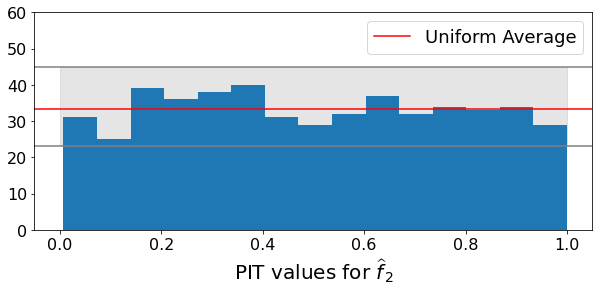

In [18]:
# good model
fig_pit_good = plot_with_uniform_band(values=pit_values, ci_level=0.95, x_label='PIT values for $\widehat f_2$', n_bins=15, ylim=[0, 60])
fig_pit_good

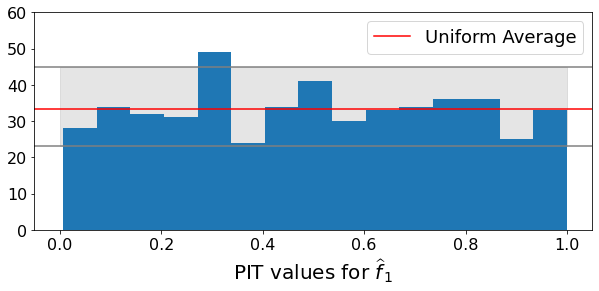

In [19]:
# bad model
fig_pit_bad = plot_with_uniform_band(values=pit_values_X, ci_level=0.95, x_label='PIT values for $\widehat f_1$', n_bins=15, ylim=[0, 60])
fig_pit_bad

# 4) global test

In [58]:
x_range = np.linspace(-2,2,41)
x1, x2 = np.meshgrid(x_range, x_range)
grid = np.hstack([x1.ravel().reshape(-1,1), x2.ravel().reshape(-1,1)])

## good model

In [59]:
global_pvalue = global_test(x_train=XZ_test, pit_train=pit_values,
                            x_test=grid,
                            alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=10)

In [60]:
global_pvalue

0.1

In [26]:
global_pvalue = global_test(x_train=XZ_test, pit_train=pit_values,
                            x_test=grid,
                            alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [22]:
global_pvalue

0.894

## bad model

In [61]:
global_pvalue = global_test(x_train=XZ_test, pit_train=pit_values_X,
                            x_test=grid,
                            alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=10)

In [62]:
global_pvalue

0.0

In [23]:
global_pvalue = global_test(x_train=XZ_test, pit_train=pit_values_X,
                            x_test=grid,
                            alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [32]:
global_pvalue

0.004

# 5) local tests

## good model

In [25]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values,
                          x_test=[(0,1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=10)

In [26]:
local_pvalue

0.7

In [21]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values,
                          x_test=[(0,0)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [22]:
local_pvalue

0.952

In [23]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values,
                          x_test=[(0,1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [24]:
local_pvalue

0.723

In [25]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values,
                          x_test=[(0,-1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [26]:
local_pvalue

0.549

## bad model

In [27]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values_X,
                          x_test=[(0,1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=10)

In [28]:
local_pvalue

0.0

In [27]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values_X,
                          x_test=[(0,0)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [28]:
local_pvalue

0.09

In [29]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values_X,
                          x_test=[(0,1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [30]:
local_pvalue

0.004

In [31]:
local_pvalue = local_test(x_train=XZ_test, pit_train=pit_values_X,
                          x_test=[(0,-1)],
                          alphas=np.linspace(0.0, 1.0, 11), clf_name='MLP', n_trials=1000)

In [32]:
local_pvalue

0.004

# 6) local P-P plots

## good model

In [18]:
XZ_test.shape

(500, 2)

In [19]:
pit_values.shape

(500,)

In [63]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values,
                    x_test=[(0,0)],
                    alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                    confidence_bands=False, conf_alpha=0.05, n_trials=10, figsize=(5,4)
                   )

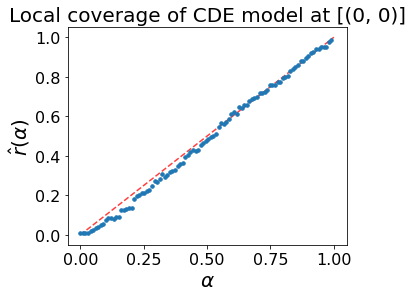

In [64]:
fig.figure

In [49]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values,
                    x_test=[(0,0)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

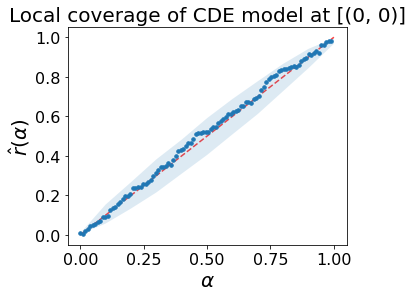

In [50]:
fig.figure

In [52]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values,
                    x_test=[(0,1)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

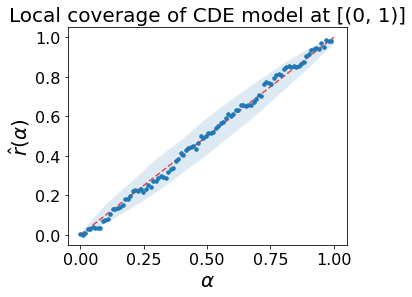

In [53]:
fig.figure

In [37]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values,
                    x_test=[(0,-1)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

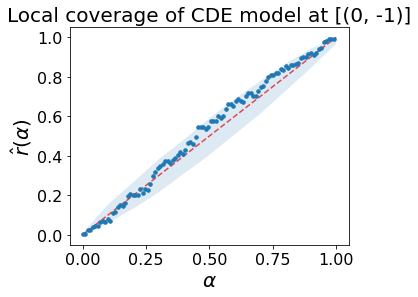

In [38]:
fig.figure

In [46]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values,
                    x_test=[(0,-1)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=False, n_trials=1000, figsize=(5,4)
                   )

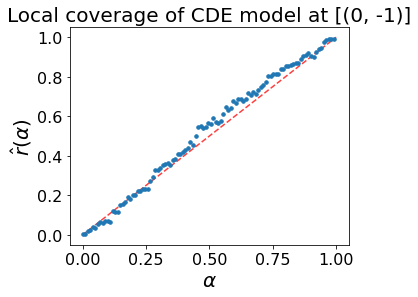

In [47]:
fig.figure

## bad model

In [37]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values_X,
                    x_test=[(0,1)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=False, conf_alpha=0.05, n_trials=10, figsize=(5,4)
                   )

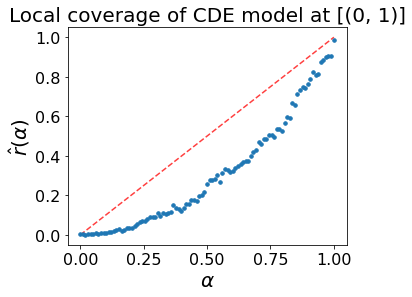

In [38]:
fig.figure

In [57]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values_X,
                    x_test=[(0,0)],
                    alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

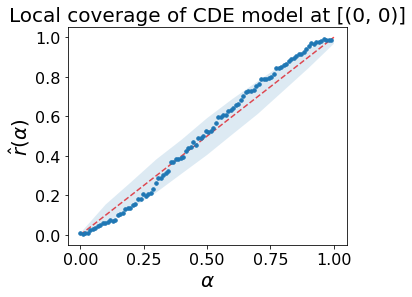

In [58]:
fig.figure

In [60]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values_X,
                    x_test=[(0,1)],
                    alphas=np.linspace(0.0, 0.999, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

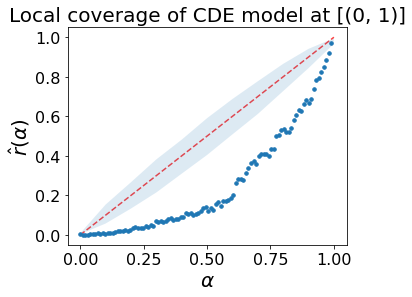

In [61]:
fig.figure

In [67]:
fig = local_pp_plot(x_train=XZ_test, pit_train=pit_values_X,
                    x_test=[(0,-1)],
                    alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                    confidence_bands=True, conf_alpha=0.05, n_trials=1000, figsize=(5,4)
                   )

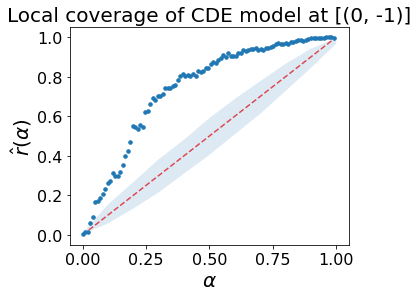

In [68]:
fig.figure

# 7) local histograms

## good model

In [20]:
fig = local_plot(x_train=XZ_test, pit_train=pit_values,
                 x_test=[(0,0)],
                 alphas=np.linspace(0.0, 0.99, 11),
                 plot_type='histogram', clf_name='MLP',
                 confidence_bands=False, conf_alpha=0.1, n_bins=7, n_trials=10, figsize=(5,4))

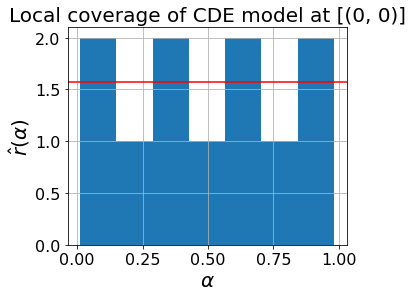

In [21]:
fig.figure

In [22]:
fig = local_plot(x_train=XZ_test, pit_train=pit_values,
                 x_test=[(0,0)],
                 alphas=np.linspace(0.0, 0.99, 11),
                 plot_type='histogram', clf_name='MLP',
                 confidence_bands=True, conf_alpha=0.1, n_bins=7, n_trials=10, figsize=(5,4))

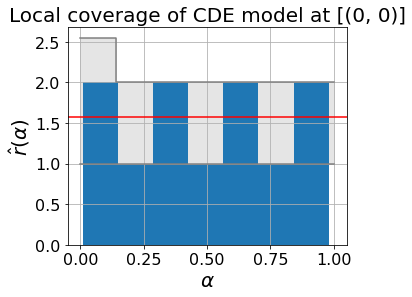

In [23]:
fig.figure

# 8) old local histograms (with binomial confidence bands)

In [49]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values,
                      x_test=[(0,0)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

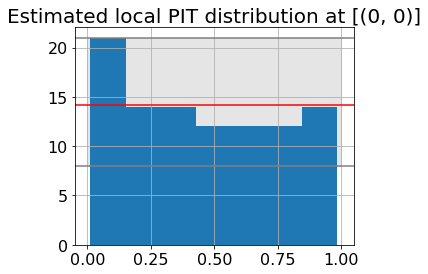

In [50]:
fig.figure

In [51]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values,
                      x_test=[(0,1)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

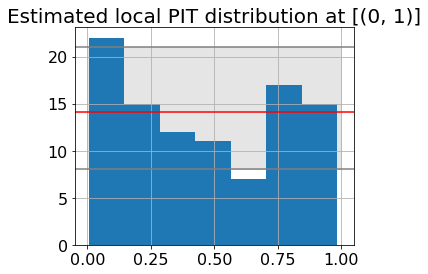

In [52]:
fig.figure

In [53]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values,
                      x_test=[(0,-1)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

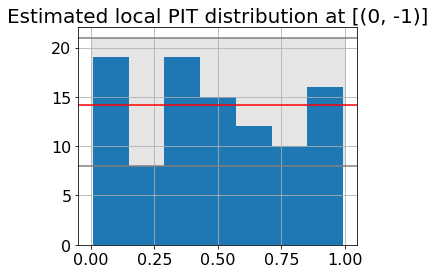

In [54]:
fig.figure

## bad model

In [55]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values_X,
                      x_test=[(0,0)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

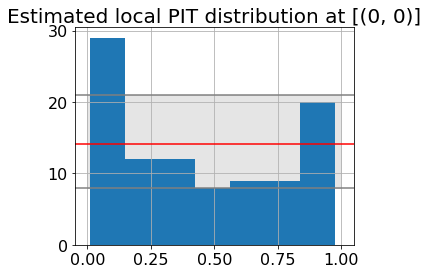

In [56]:
fig.figure

In [57]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values_X,
                      x_test=[(0,1)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

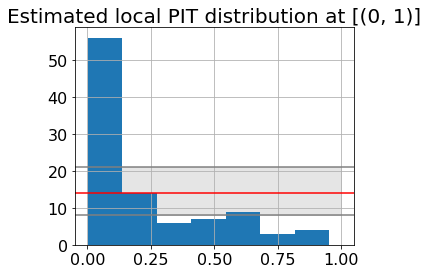

In [58]:
fig.figure

In [59]:
fig = local_histogram(x_train=XZ_test, pit_train=pit_values_X,
                      x_test=[(0,-1)],
                      alphas=np.linspace(0.0, 0.99, 99), clf_name='MLP',
                      ci_level=0.05, n_bins=7, figsize=(5,4)
                     )

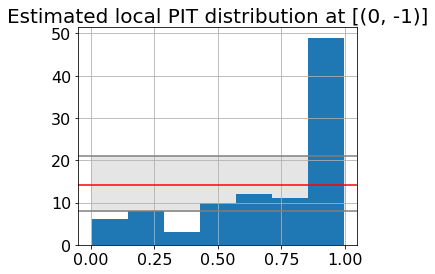

In [60]:
fig.figure